In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

captions.txt  Images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase3'

import sys
sys.path.append('/content/drive/MyDrive/phase3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [ ]:
# Configuration
image_size = (112, 112)
data_paht = f"{path}/Images"
captions_path = f"{path}/captions.txt"
data_dict_path = f"{base_dir}/image_captioning_dataset.pt"

data_dict = load_data(data_dict_path, captions_path, data_paht, image_size)

/content/drive/MyDrive/phase3/ph3.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


Dataset loaded successfully.


In [ ]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 6472
num_val: 1619


In [ ]:
data_dict['train_images'].shape

torch.Size([6472, 3, 112, 112])

In [ ]:
data_dict['train_captions'].shape

torch.Size([6472, 5, 40])

In [ ]:
len(data_dict["vocab"]["idx_to_token"])

8908

We have 6,472 lists of captions.

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [ ]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

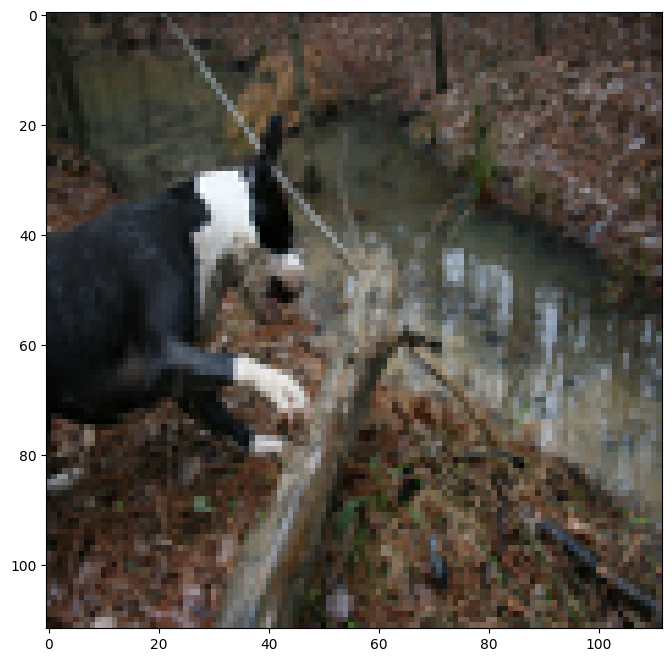

In [ ]:
plt.imshow(data_dict['train_images'][0].permute(1, 2, 0))

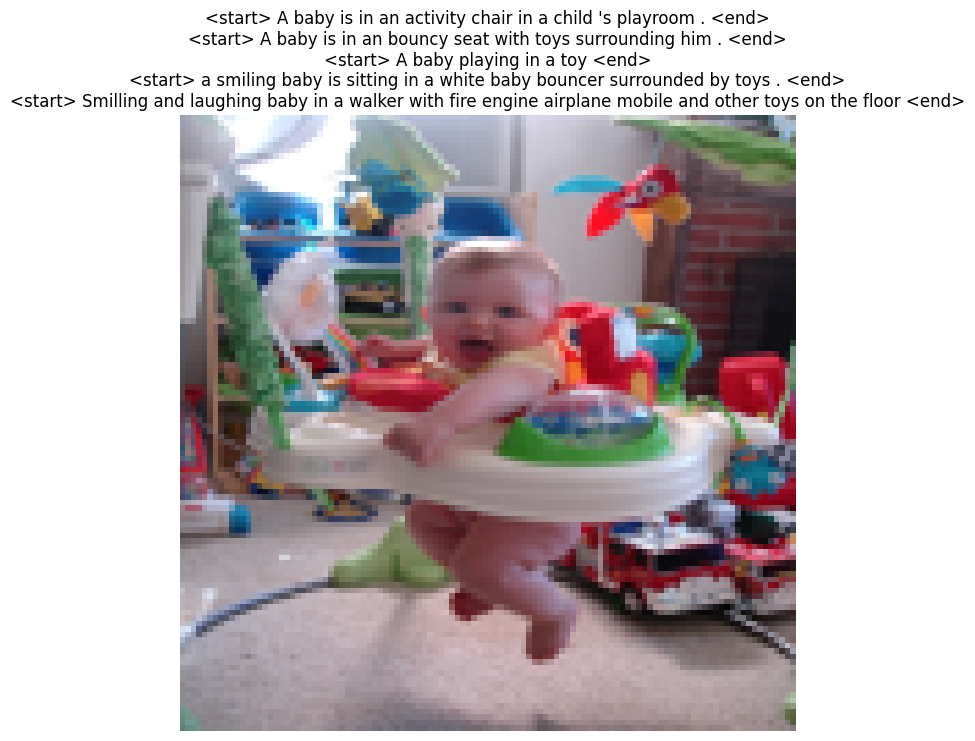

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 1

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  caption_str = "\n".join(caption_str)
  plt.title(caption_str)
  plt.show()

### RNN

In [ ]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280,
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

In [ ]:
lr = 1e-3
epochs = 120
lr_decay = 1
batch_size=256
weight_decay = 5e-4

# Model and file paths
name = 'attention'
version = 3
checkpoint_path = f'{base_dir}/checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'{base_dir}/models/{name}_{version}_checkpoint.pth'
history_path = f'{base_dir}/history/{name}_{version}.pth'


if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr)

    optimizer.load_state_dict(checkpoint['optimizer_state'])

    scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0

# Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32,
    epochs=epochs, batch_size=batch_size, scheduler=scheduler, val_perc=1,
    verbose=True, checkpoint_path=checkpoint_path
)


# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")



Resuming training from checkpoint: /content/drive/MyDrive/phase3/checkpoint/attention_3_checkpoint.pth


<ipython-input-32-97e12f9d94cc>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Training will resume from epoch 112.

Resuming training from checkpoint...
Resumed training from epoch 112
Epoch 113/120


/content/drive/MyDrive/phase3/ph3.py:936: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


  Batch 1/25, Loss = 9.0455
  Batch 11/25, Loss = 8.9295
  Batch 21/25, Loss = 9.0765
  Training Loss: 8.8153
  Validation Loss: 71.0866
Epoch 114/120
  Batch 1/25, Loss = 9.2536
  Batch 11/25, Loss = 8.9235
  Batch 21/25, Loss = 9.4257
  Training Loss: 8.8486
  Validation Loss: 71.1935
Epoch 115/120
  Batch 1/25, Loss = 9.4164
  Batch 11/25, Loss = 8.9370
  Batch 21/25, Loss = 9.3764
  Training Loss: 8.8388
  Validation Loss: 71.5441
Epoch 116/120
  Batch 1/25, Loss = 9.7303
  Batch 11/25, Loss = 8.9257
  Batch 21/25, Loss = 9.2860
  Training Loss: 8.8813
  Validation Loss: 71.7501
Epoch 117/120
  Batch 1/25, Loss = 9.3525
  Batch 11/25, Loss = 8.6991
  Batch 21/25, Loss = 9.0934
  Training Loss: 8.7289
  Validation Loss: 71.9346
Epoch 118/120
  Batch 1/25, Loss = 9.1144
  Batch 11/25, Loss = 8.8571
  Batch 21/25, Loss = 8.8489
  Training Loss: 8.5458


In [ ]:
plt.plot(train_loss_history)

In [ ]:
plt.plot(val_loss_history)

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms

class FeatureExtractor:
    """
    Image feature extraction using InceptionV3.
    """

    def __init__(self, pooling=False, device='cuda', dtype=torch.float32):
        self.device = device
        self.dtype = dtype
        self.pooling = pooling

        # Define preprocessing transformations
        self.preprocess = transforms.Compose([
            transforms.Resize((299, 299)),  # InceptionV3 expects 299x299 images
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        # Load pretrained InceptionV3 model
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        self.inception = self.inception.to(device).eval()

        # Remove the final classification layer and auxiliary classifier
        self.inception = nn.Sequential(*list(self.inception.children())[:-1])

        # Add global average pooling if specified
        if self.pooling:
            self.inception.add_module('GlobalAvgPool', nn.AdaptiveAvgPool2d((1, 1)))

    def extract_features(self, img_batch):
        """
        Extract features from a batch of images.

        Args:
            img_batch (torch.Tensor): Batch of images with shape (N, 3, H, W).

        Returns:
            torch.Tensor: Extracted features with shape:
                          - (N, 2048) if pooling is True
                          - (N, 2048, 8, 8) if pooling is False
        """
        # Preprocess images
        img_batch = torch.stack([self.preprocess(img) for img in img_batch])
        img_batch = img_batch.to(self.device, dtype=self.dtype)

        with torch.no_grad():
            features = self.inception(img_batch)

        if self.pooling:
            features = features.view(features.size(0), -1)  # Flatten to (N, 2048)

        return features
f = FeatureExtractor()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/mahdi/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [11:56<00:00, 152kB/s]  
